#### Activation and Batch Normalization

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(214)
C = torch.randn((vocab_size,n_embd),generator =g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator =g)
b1 = torch.randn(n_hidden , generator =g)
W2 = torch.randn((n_hidden , vocab_size),generator =g)
b2 = torch.randn(vocab_size,generator =g)
parameters = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [51]:
max_steps = 200000
batch_size = 32
lossi=[]

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator = g)
  Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0] ,-1) #concate vectors
  hpreact = embcat @ W1 + b1 # hiddedn pre activation
  h = torch.tanh(hpreact) # hidden
  logits = h @ W2 + b2 # out
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

#print(loss.item())

      0/ 200000: 22.8103
  10000/ 200000: 2.6895
  20000/ 200000: 2.4221
  30000/ 200000: 2.2064
  40000/ 200000: 2.1196
  50000/ 200000: 1.8162
  60000/ 200000: 2.3228
  70000/ 200000: 2.4542
  80000/ 200000: 2.4901
  90000/ 200000: 2.0304
 100000/ 200000: 2.2336
 110000/ 200000: 1.8717
 120000/ 200000: 1.8195
 130000/ 200000: 2.2100
 140000/ 200000: 2.0501
 150000/ 200000: 2.0007
 160000/ 200000: 2.1553
 170000/ 200000: 1.9617
 180000/ 200000: 2.1274
 190000/ 200000: 2.0800


In [53]:
logits[0]

tensor([  0.9982,   5.5515,  -4.0297,  -3.9381,  -6.9551,   3.1348,  -2.6888,
         -9.9456,  -5.9183,   4.4835,  -4.4895,  -9.7056,  -3.0283,  -6.2236,
         -4.6159,   1.5790,  -4.1420,  -8.4462,  -4.1086,  -3.6283,  -2.3293,
         -0.0328,  -5.5885,  -8.8652, -12.3062,   2.7883,  -4.3371],
       grad_fn=<SelectBackward0>)

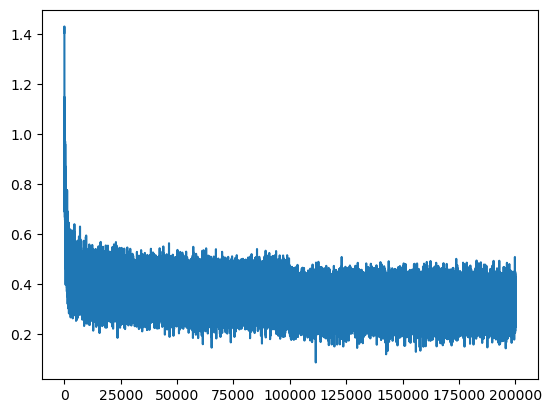

In [21]:
plt.plot(lossi)
plt.show()

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.3108179569244385
val 3.343069553375244


In [19]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpavelai.
harli.
jari.
reh.
cassanden.
jazonen.
delynn.
jarqui.
nellara.
chaiiv.
kaleigph.
bryn.
cateen.
tis.
lilea.
jamique.
jero.
dearystifpy.
kairuston.
demiia.


In [27]:
1/27

0.037037037037037035

In [29]:
-torch.tensor(1/27.0).log()  # Average loss it should be

tensor(3.2958)

In [31]:
##BUT is u see in the first iteration the loss is 27 which we can improve

In [33]:
## This happens because of randomly initialized weights

In [55]:
logits[0]

tensor([  0.9982,   5.5515,  -4.0297,  -3.9381,  -6.9551,   3.1348,  -2.6888,
         -9.9456,  -5.9183,   4.4835,  -4.4895,  -9.7056,  -3.0283,  -6.2236,
         -4.6159,   1.5790,  -4.1420,  -8.4462,  -4.1086,  -3.6283,  -2.3293,
         -0.0328,  -5.5885,  -8.8652, -12.3062,   2.7883,  -4.3371],
       grad_fn=<SelectBackward0>)

In [57]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(214)
C = torch.randn((vocab_size,n_embd),generator =g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator =g)
b1 = torch.randn(n_hidden , generator =g)
W2 = torch.randn((n_hidden , vocab_size),generator =g)
b2 = torch.randn(vocab_size,generator =g)
parameters = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [59]:
max_steps = 200000
batch_size = 32
lossi=[]

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator = g)
  Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0] ,-1) #concate vectors
  hpreact = embcat @ W1 + b1 # hiddedn pre activation
  h = torch.tanh(hpreact) # hidden
  logits = h @ W2 + b2 # out
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

#print(loss.item())

      0/ 200000: 22.8103


In [61]:
logits[0]

tensor([ 16.2302,  10.9687,   8.1513,  10.7653,  -1.5868,  15.9697,  18.4443,
          5.3465,  -6.2597,  13.0162,  -0.0960,  11.4786, -12.9771,   3.4785,
        -21.7663, -14.2289,  12.2512,  -2.7778,  13.4412, -10.3855,  -3.8728,
          6.6951, -12.4779,  -5.9018,  24.5830,   2.7310,   4.4197],
       grad_fn=<SelectBackward0>)

#### fixing softmax i.e logits

In [63]:
#if u see logits are very large at first

In [ ]:
# logits = h @ W2 + b2 # out
# So we make b =0 and W2 smaller

In [69]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(214)
C = torch.randn((vocab_size,n_embd),generator =g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator =g)
b1 = torch.randn(n_hidden , generator =g)
W2 = torch.randn((n_hidden , vocab_size),generator =g) * 0.01
b2 = torch.randn(vocab_size,generator =g) * 0 
parameters = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [71]:
max_steps = 200000
batch_size = 32
lossi=[]

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator = g)
  Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0] ,-1) #concate vectors
  hpreact = embcat @ W1 + b1 # hiddedn pre activation
  h = torch.tanh(hpreact) # hidden
  logits = h @ W2 + b2 # out
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

#print(loss.item())

      0/ 200000: 3.2962


In [73]:
logits[0]

tensor([ 0.1522,  0.1025,  0.0868,  0.1047, -0.0054,  0.1634,  0.1736,  0.0379,
        -0.0887,  0.1157, -0.0063,  0.1071, -0.1241,  0.0408, -0.1982, -0.1576,
         0.1041, -0.0394,  0.1395, -0.1201, -0.0365,  0.0688, -0.1200, -0.0638,
         0.2401,  0.0180,  0.0180], grad_fn=<SelectBackward0>)

In [75]:
h

tensor([[ 1.0000,  0.9975, -0.9957,  ..., -0.9977, -0.9091, -1.0000],
        [ 0.9987,  1.0000, -1.0000,  ...,  1.0000,  1.0000, -0.9666],
        [ 0.9912, -0.9986, -0.9984,  ...,  0.2583,  0.0590, -1.0000],
        ...,
        [-0.5602, -1.0000, -0.9924,  ...,  0.9455,  0.5716, -0.9997],
        [ 1.0000,  0.9975, -0.9957,  ..., -0.9977, -0.9091, -1.0000],
        [ 1.0000,  0.9975, -0.9957,  ..., -0.9977, -0.9091, -1.0000]],
       grad_fn=<TanhBackward0>)

In [77]:
h.shape

torch.Size([32, 200])

In [81]:
h.view(-1).shape

torch.Size([6400])

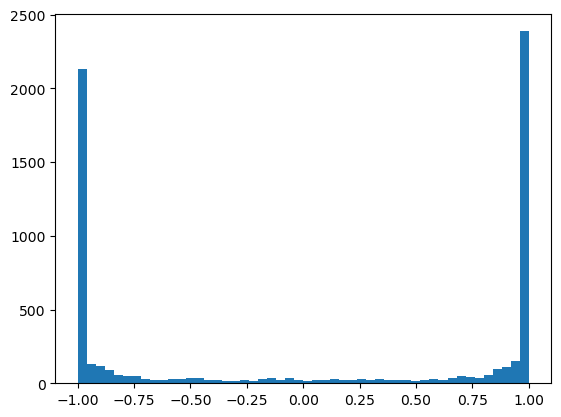

In [83]:
plt.hist(h.view(-1).tolist(), 50);
plt.show()

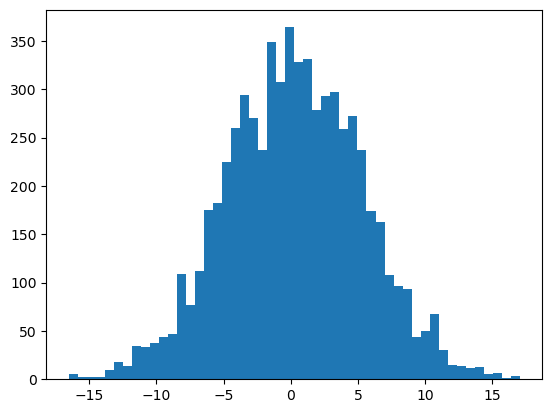

In [85]:
plt.hist(hpreact.view(-1).tolist(), 50);
plt.show()

### if tanh value is close to 1 ,-1 then bacward value will be 0
### remmber the tanh distribution is like S so when the values are extrene side no matter if u change the value it be already on platue i.e top or bottom part of S curve so there wont be much change

In [93]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99 , cmap = "gray", interpolation = 'nearest')

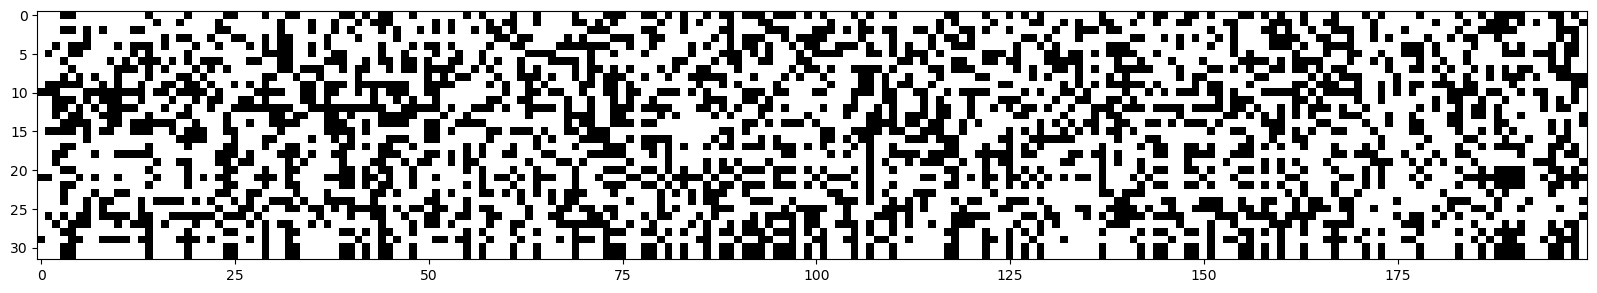

In [95]:
plt.show()

### here white spaces are tanh =0 so suppose if there is an entire line with just white meaning
### tanh =0 then its a dead neuron

### Even in Relu if its -ve values then its dead .  Some times happens in initialization or during optimization when we have high learning rate then gradient will be extreme and it will become dead

### This tanh is having extreme values because h value is in high distribution so we can
### reduce the value of h by decreasing w1 and b1

In [124]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(214)
C = torch.randn((vocab_size,n_embd),generator =g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator =g) * 0.2
b1 = torch.randn(n_hidden , generator =g) * 0.01
W2 = torch.randn((n_hidden , vocab_size),generator =g) * 0.01
b2 = torch.randn(vocab_size,generator =g) * 0 
parameters = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [126]:
max_steps = 200000
batch_size = 32
lossi=[]

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator = g)
  Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0] ,-1) #concate vectors
  hpreact = embcat @ W1 + b1 # hiddedn pre activation
  h = torch.tanh(hpreact) # hidden
  logits = h @ W2 + b2 # out
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

#print(loss.item())

      0/ 200000: 3.2932


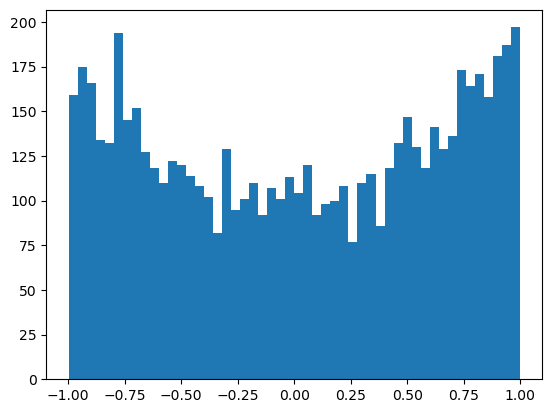

In [128]:
plt.hist(h.view(-1).tolist(), 50);
plt.show()

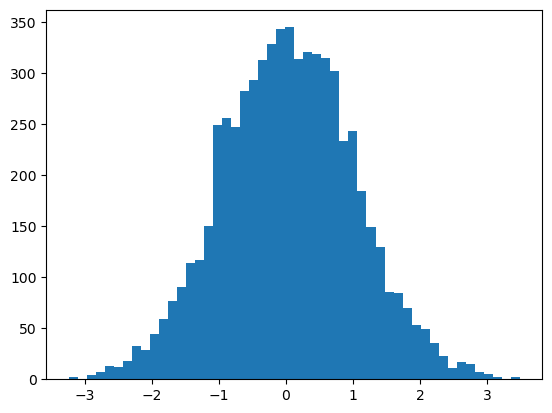

In [130]:
plt.hist(hpreact.view(-1).tolist(), 50);
plt.show()

In [132]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99 , cmap = "gray", interpolation = 'nearest')

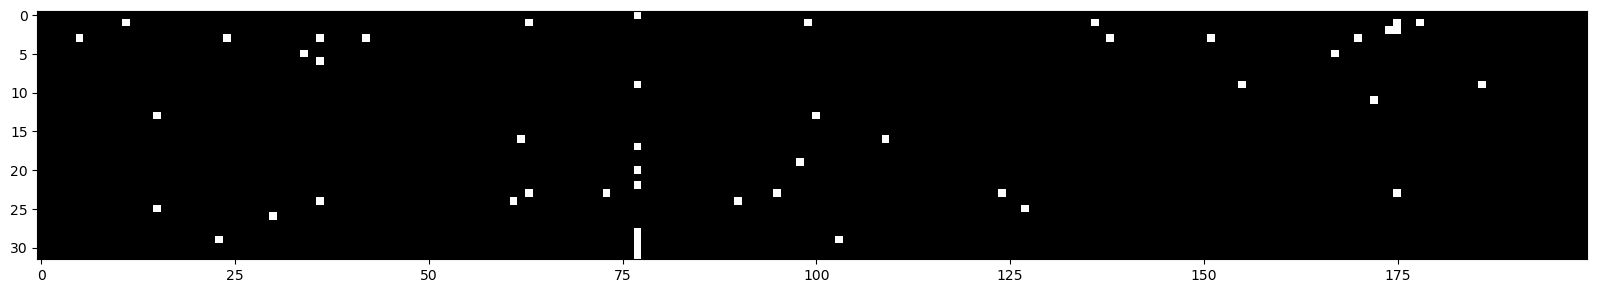

In [134]:
plt.show()

#### If you see tanhh graph there are no nurons that are above -1 and 1 so its all black

In [138]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(214)
C = torch.randn((vocab_size,n_embd),generator =g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator =g) * 0.2
b1 = torch.randn(n_hidden , generator =g) * 0.01
W2 = torch.randn((n_hidden , vocab_size),generator =g) * 0.01
b2 = torch.randn(vocab_size,generator =g) * 0 
parameters = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [140]:
max_steps = 200000
batch_size = 32
lossi=[]

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator = g)
  Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0] ,-1) #concate vectors
  hpreact = embcat @ W1 + b1 # hiddedn pre activation
  h = torch.tanh(hpreact) # hidden
  logits = h @ W2 + b2 # out
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
#print(loss.item())

      0/ 200000: 3.2932
  10000/ 200000: 2.4835
  20000/ 200000: 2.1118
  30000/ 200000: 2.1184
  40000/ 200000: 2.0628
  50000/ 200000: 1.8544
  60000/ 200000: 2.0020
  70000/ 200000: 2.4049
  80000/ 200000: 2.1180
  90000/ 200000: 1.9363
 100000/ 200000: 2.0518
 110000/ 200000: 1.8418
 120000/ 200000: 1.8344
 130000/ 200000: 2.1096
 140000/ 200000: 1.9204
 150000/ 200000: 1.8611
 160000/ 200000: 1.9554
 170000/ 200000: 1.8610
 180000/ 200000: 2.0613
 190000/ 200000: 2.0286


In [142]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.238511562347412
val 2.2973506450653076


In [147]:
### By fixing these weights we go better loss 

tensor(-0.0010) tensor(0.9994)
tensor(0.0036) tensor(3.1576)


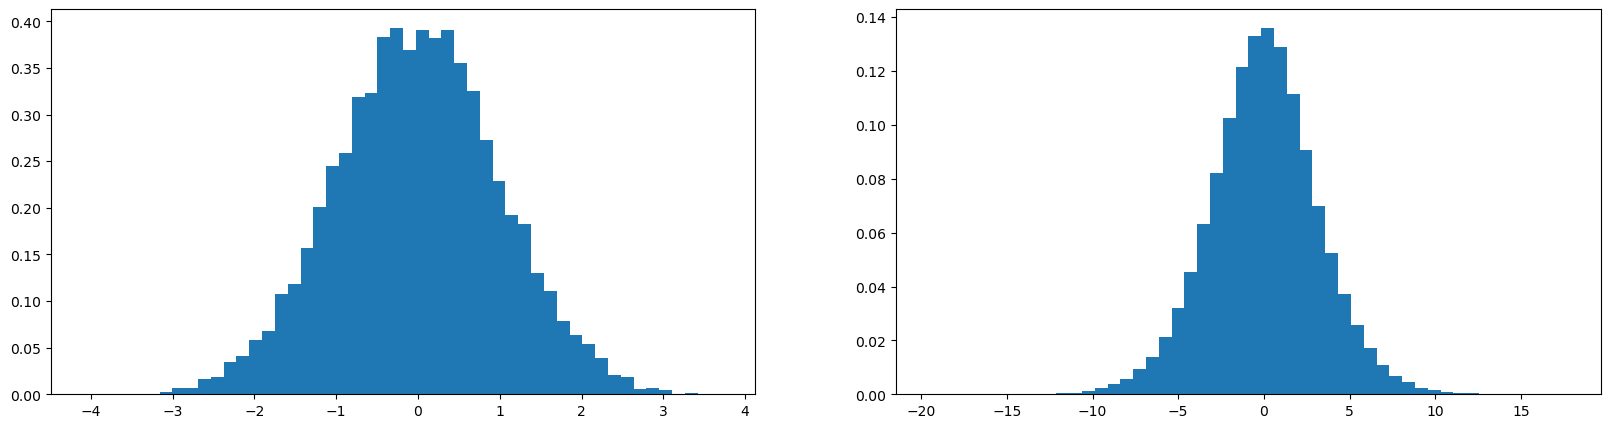

In [155]:
x = torch.randn(1000,10)
w = torch.randn(10 , 200)
y=x@w
print(x.mean() ,x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

In [157]:
# If u see both x , w are gaussiian distribution  and if u multiply their std becoming very large

tensor(0.0027) tensor(0.9988)
tensor(0.0019) tensor(15.7905)


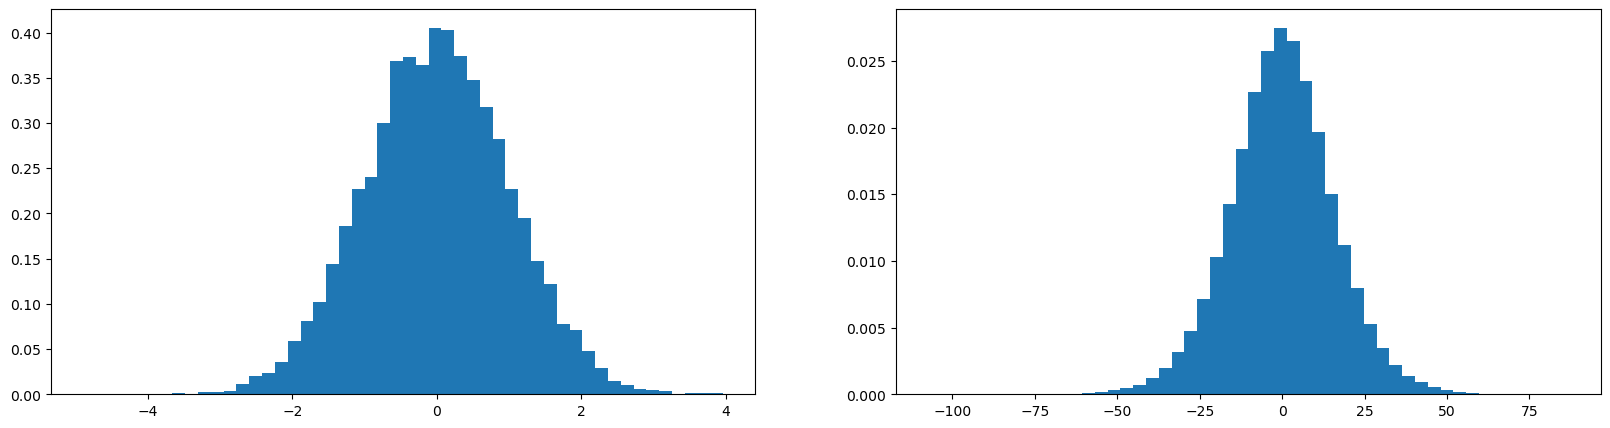

In [159]:
x = torch.randn(1000,10)
w = torch.randn(10 , 200) * 5
y=x@w
print(x.mean() ,x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

tensor(0.0022) tensor(1.0040)
tensor(-0.0016) tensor(0.6396)


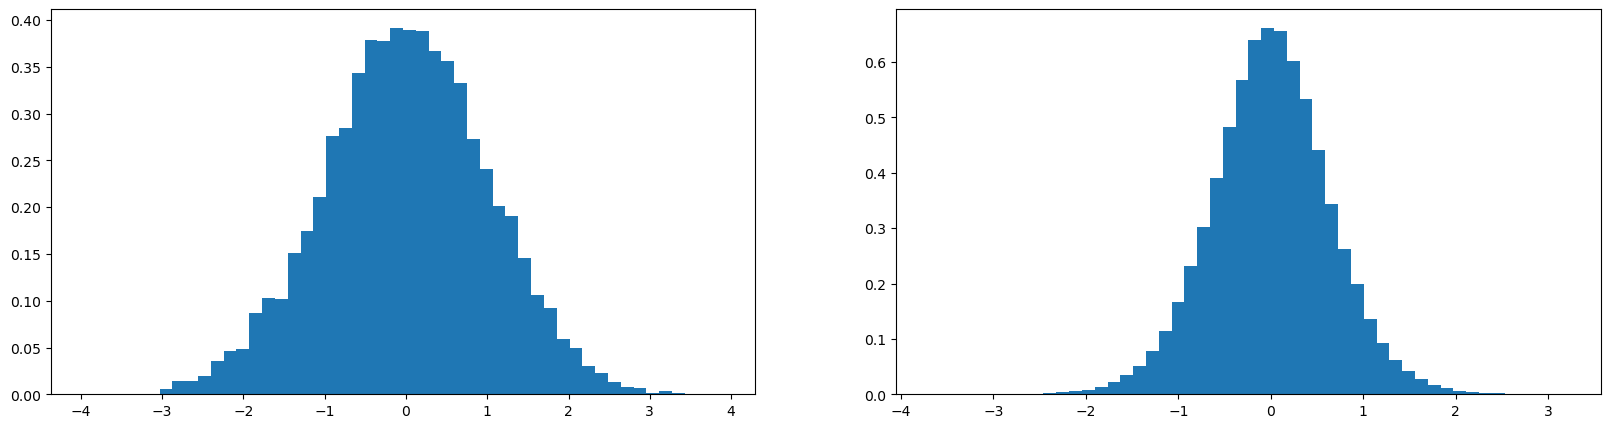

In [161]:
x = torch.randn(1000,10)
w = torch.randn(10 , 200) * 0.2
y=x@w
print(x.mean() ,x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

In [163]:
## in order to keep the std close to 1 after x@w we need to

tensor(-0.0156) tensor(1.0075)
tensor(0.0015) tensor(1.0003)


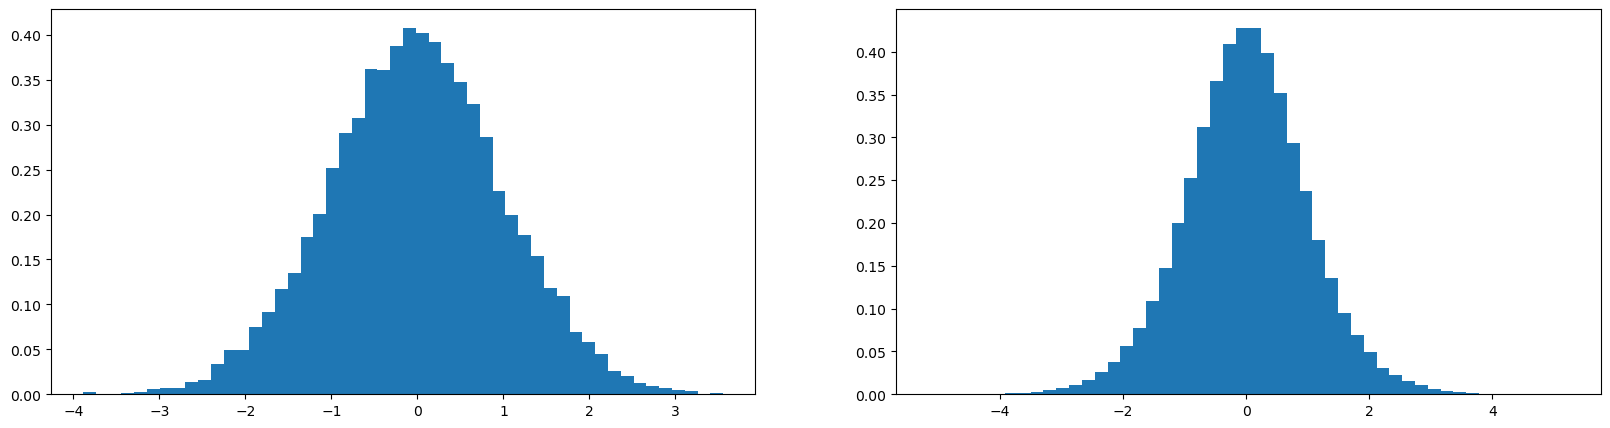

In [168]:
x = torch.randn(1000,10)
w = torch.randn(10 , 200) / 10**0.5 # square root this is usuall we do for everything but moslty for RELU
y=x@w
print(x.mean() ,x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

In [170]:
# for tanh instead of sqrt we do 5/3

In [172]:
torch.randn(10000).std()

tensor(1.0035)

In [174]:
(torch.randn(10000)*0.2).std()

tensor(0.2027)

In [176]:
## so for gaussiona dist what ever u multiply u get that much

In [178]:
## for all there there is a suggested std deviation that is best for the model

In [ ]:
## for tanh it is (5/3)/n**0.5

In [180]:
n_embd * block_size

30

In [182]:
(5/3)/30**0.5

0.3042903097250923

In [208]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(214)
C = torch.randn((vocab_size,n_embd),generator =g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator =g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden , generator =g) * 0.01
W2 = torch.randn((n_hidden , vocab_size),generator =g) * 0.01
b2 = torch.randn(vocab_size,generator =g) * 0 
parameters = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


## we are doing this because during the initialization we want the distribution of weights@X to be roughly gaussioan i.e std == 1 
### as if its too distributed we will get bad tanh values as discussed above

#### There weight tweaking is old method cuurently we use residual connections to initialize the weights and batch normalization and other normalization and also optimizer like adam are imporved 

## Batch Normalization

 #### So u just normaize the hidden states to make it roughly gaussian

In [194]:
hpreact.shape

torch.Size([32, 200])

In [196]:
hpreact.mean(0, keepdim = True).shape

torch.Size([1, 200])

In [198]:
hpreact.std(0, keepdim = True).shape

torch.Size([1, 200])

In [200]:
# norm =  X- mu / sigma

In [212]:
# all this is differentiable and we call it batch as we are standerdizing by batch

In [210]:
max_steps = 200000
batch_size = 32
lossi=[]

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator = g)
  Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0] ,-1) #concate vectors
  hpreact = embcat @ W1 + b1 # hiddedn pre activation
  hpreact = (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True)
    # norm =  X- mu / sigma
  h = torch.tanh(hpreact) # hidden
  logits = h @ W2 + b2 # out
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
#print(loss.item())

      0/ 200000: 3.2914


### we want these weights to be gaussian only at initialization and we dont want to force it for all the iterations.
### So we use some scaling parameters at first we multiply with 1 and add with 0 so at start it will star with gaussion dist and then during back prop it will change these parameters

In [217]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(214)
C = torch.randn((vocab_size,n_embd),generator =g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator =g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden , generator =g) * 0.01
W2 = torch.randn((n_hidden , vocab_size),generator =g) * 0.01
b2 = torch.randn(vocab_size,generator =g) * 0 



bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

parameters = [C,W1,b1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [221]:
max_steps = 200000
batch_size = 32
lossi=[]

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator = g)
  Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0] ,-1) #concate vectors
  hpreact = embcat @ W1 + b1 # hiddedn pre activation
  hpreact = bngain*(hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
    # norm =  X- mu / sigma
  h = torch.tanh(hpreact) # hidden
  logits = h @ W2 + b2 # out
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break
#print(loss.item())

      0/ 200000: 3.3241
  10000/ 200000: 2.2082
  20000/ 200000: 2.2799
  30000/ 200000: 1.9561
  40000/ 200000: 2.2341
  50000/ 200000: 1.8756
  60000/ 200000: 2.1382
  70000/ 200000: 1.7352
  80000/ 200000: 2.0401
  90000/ 200000: 1.9723
 100000/ 200000: 2.1778
 110000/ 200000: 1.6824
 120000/ 200000: 2.2427
 130000/ 200000: 2.4277
 140000/ 200000: 1.7366
 150000/ 200000: 2.4130
 160000/ 200000: 1.9599
 170000/ 200000: 1.8940
 180000/ 200000: 2.1312
 190000/ 200000: 1.9548


In [223]:
# adding Batch normalizaion at test time also

In [224]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain*(hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.067873954772949
val 2.1115970611572266


### Here batch normalization expects batch , so during inference if u need only one sample it wont work

In [235]:
### SO u keep track of  bnmean_running,bnstd_running during training of NN

In [231]:
n_embd = 10
n_hidden = 200

g= torch.Generator().manual_seed(214)
C = torch.randn((vocab_size,n_embd),generator =g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator =g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden , generator =g) * 0.01
W2 = torch.randn((n_hidden , vocab_size),generator =g) * 0.01
b2 = torch.randn(vocab_size,generator =g) * 0 



bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,b1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [233]:
max_steps = 200000
batch_size = 32
lossi=[]

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,) , generator = g)
  Xb ,Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # (32, 3, 10)
  embcat = emb.view(emb.shape[0] ,-1) #concate vectors
  hpreact = embcat @ W1 + b1 # hiddedn pre activation
  # hpreact = bngain*(hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
    # norm =  X- mu / sigma
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
      
  h = torch.tanh(hpreact) # hidden
  logits = h @ W2 + b2 # out
  loss = F.cross_entropy(logits, Yb)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
#print(loss.item())

      0/ 200000: 3.2914


In [237]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.2792696952819824
val 3.2793285846710205


#### when using the batch norm the layer before batch norm baises will not be usefull so we generally remove those as batch norm has its own "bnbias" it worksk fine

### BATCH NORM - To control the statistics of weights

In [246]:
## we can do weigts vs grad
## grad upadtes vd data graphs